In [68]:
#%pip install tensorflow

In [69]:
#%pip install --upgrade tensorflow-hub

In [70]:
import os
import numpy as np
import cv2
import glob as glob
import json

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import warnings
import logging
import absl

from random import randint


# Filter absl warnings
warnings.filterwarnings("ignore", module="absl")

# Capture all warnings in the logging system
logging.captureWarnings(True)

# Set the absl logger level to 'error' to suppress warnings
absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [71]:
#%pip install torch torchvision

In [72]:
#%pip install segment-geospatial groundingdino-py leafmap localtileserver

In [73]:
import leafmap
from samgeo import tms_to_geotiff
from samgeo.text_sam import LangSAM

### 1.1 Display Sample Images

In [74]:
from PIL import Image 
 
jpg_folder = r'jpgs\rs19_val'
# Use the os.listdir function to list the files in the folder 
image_files = os.listdir(jpg_folder)
 
map_folder = r'uint8\rs19_val'
# Use the os.listdir function to list the files in the folder 
map_files = os.listdir(map_folder)

inp_path_config_json = "rs19-config.json"
class_index = json.load(open(inp_path_config_json, 'r'))



class_index is a dictionary that maps all 19 classes in the Railsem dataset with their associated class IDs and RGB color labels.

In [75]:
# generate random numbers between 0-8500
sampl = randint(0, 8500)
image_filename = image_files[sampl]
map_filename = map_files[sampl]

image_path = 'jpgs/rs19_val/{}'.format(image_filename)
label_path = 'uint8/rs19_val/{}'.format(map_filename)

im_jpg = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
im_id_map = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE) #get semantic label map

In [101]:
image_filename


'rs02930.jpg'

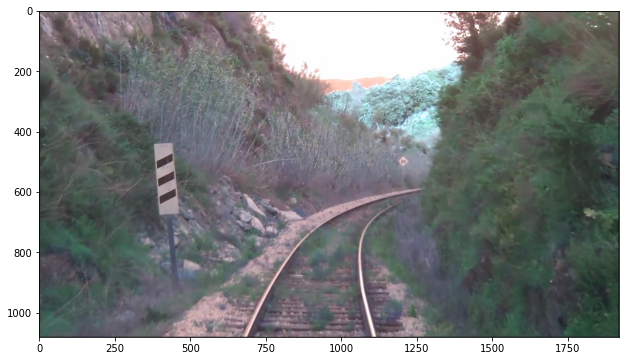

In [76]:
plt.figure(figsize=(20,6))
plt.imshow(im_jpg)

In [129]:
import torch

In [159]:
from transformers import AutoProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests

processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

image_pil = Image.open(image_path).convert("RGB")

texts = ["vegetation"]
inputs = processor(text=texts, images=[image_pil] * len(texts), return_tensors="pt")

outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([352, 352])


In [ ]:
image_pil = Image.open(image_path).convert("RGB")
text_prompt = "vegetation"

In [167]:
texts = ["vegetation"]
inputs = processor(text=texts, images=[image_pil] * len(texts), padding=True, return_tensors="pt")

outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([352, 352])


In [165]:
image = im_jpg

In [191]:
near_img = cv2.resize(logits,None, fx = 10, fy = 10, interpolation = cv2.INTER_NEAREST)

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [77]:
sam = LangSAM()

final text_encoder_type: bert-base-uncased


In [78]:
image_pil = Image.open(image_path).convert("RGB")
text_prompt = "vegetation"

In [121]:
text_prompt = "railway"

In [122]:
sam.predict(image_pil, text_prompt, box_threshold=0.24, text_threshold=0.24)

In [123]:
def combine_masks(masks):
    total_mask = tf.zeros_like(masks[0], dtype=tf.uint8)

    for mask in masks:
        total_mask = tf.math.maximum(total_mask, mask)

    return total_mask

# Example usage:
# Assuming masks_list is a list of individual masks (binary images)

total_mask = combine_masks(sam.masks)


In [124]:
def display_image_with_masks(image, masks):
    num_masks = len(masks)

    num_rows = (num_masks + 1) // 4 + 1
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, 5 * num_rows))

    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    for i, mask_np in enumerate(masks):
        row = (i + 1) // 4
        col = (i + 1) % 4
        axes[row, col].imshow(mask_np, cmap='gray')
        axes[row, col].set_title(f"Mask {i+1}")
        axes[row, col].axis('off')

    # Hide any remaining empty subplots
    for i in range((num_rows * 4) - num_masks):
        row = (num_masks + i) // 4
        col = (num_masks + i) % 4
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# display_image_with_masks(original_image, [mask1, mask2, mask3, mask4, mask5, mask6, mask7, mask8])



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

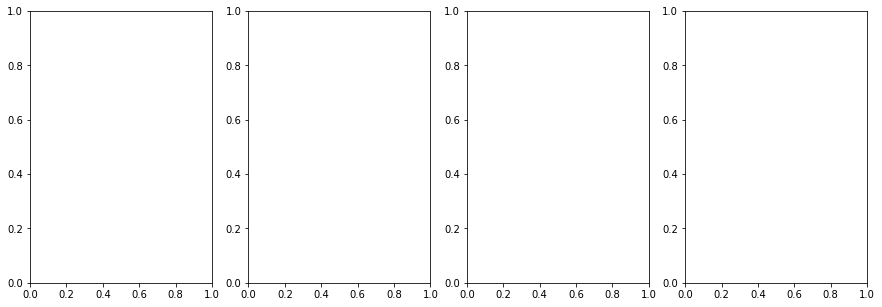

In [125]:
display_image_with_masks(sam.image,sam.masks)

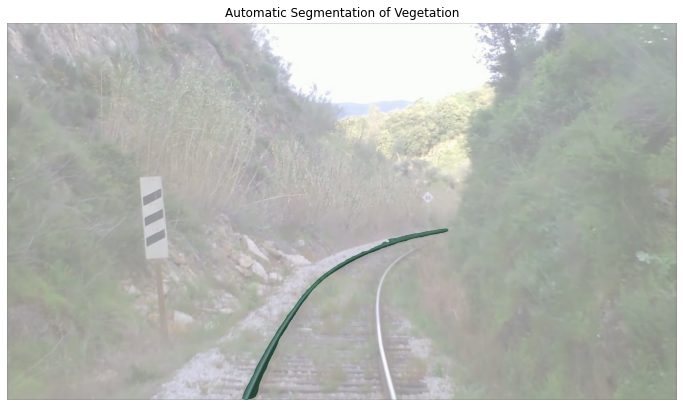

In [126]:
sam.show_anns(
    cmap='Greens',
    add_boxes=False,
    alpha=0.5,
    title='Automatic Segmentation of Vegetation',
)

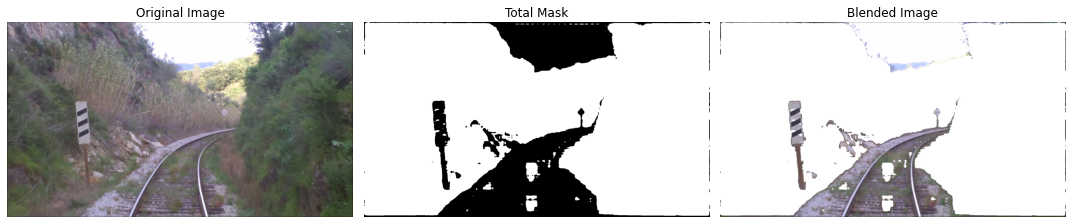

In [84]:
def combine_masks(masks):
    total_mask = tf.zeros_like(masks[0], dtype=tf.uint8)

    for mask in masks:
        total_mask = tf.math.maximum(total_mask, mask)

    return total_mask

def display_image_with_masks_and_blend(image, masks):
    total_mask = combine_masks(masks)

    # Expand dimensions of the mask to match the number of channels in the image
    total_mask_expanded = tf.expand_dims(total_mask, axis=-1)

    # Create a blended image by applying the total mask
    blended_image = image * (1 - total_mask_expanded) + total_mask_expanded * 255

    # Convert the blended image to uint8
    blended_image = tf.cast(blended_image, tf.uint8)

    num_masks = len(masks)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(total_mask, cmap='gray')
    axes[1].set_title("Total Mask")
    axes[1].axis('off')

    axes[2].imshow(blended_image.numpy())
    axes[2].set_title("Blended Image")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming original_image is your original image tensor and masks_list is a list of individual masks
# display_image_with_masks_and_blend(original_image, masks_list)


# Example usage:
# Assuming original_image is your original image and masks_list is a list of individual masks
display_image_with_masks_and_blend(image_pil, sam.masks)


In [85]:
def calculate_iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    
    iou = intersection / union
    return iou.numpy()  # If you need the result as a NumPy array

# Example usage:
# Assuming y_true and y_pred are binary masks with values 0 and 1
# iou_value = calculate_iou(y_true, y_pred)


In [86]:
interested_array = np.where(np.isin(im_id_map, [8,9]), 8, 0)

In [87]:
# Assuming total_mask is a TensorFlow tensor
total_mask_np = total_mask.numpy()

unique_values, counts = np.unique(total_mask_np, return_counts=True)

for value, frequency in zip(unique_values, counts):
    print(f"Value: {value}, Total Frequency: {frequency}")

Value: 0, Total Frequency: 434512
Value: 1, Total Frequency: 1639088


In [88]:
total_mask_veg =  np.where(np.isin(total_mask_np, [1]), 8, 0)

In [89]:
unique_values, counts = np.unique(interested_array, return_counts=True)

for value, frequency in zip(unique_values, counts):
    print(f"Value: {value}, Total Frequency: {frequency}")

Value: 0, Total Frequency: 334032
Value: 8, Total Frequency: 1739568


In [90]:
def calculate_iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    
    iou = intersection / union
    return iou.numpy()  # If you need the result as a NumPy array

# Example usage:
# Assuming y_true and y_pred are binary masks with values 0 and 1

iou_value = calculate_iou(interested_array, total_mask_np)


In [91]:
iou_value

0.9248557533254028

In [92]:
import json

In [93]:
inp_path_config_json = "rs19-config.json"
class_index = json.load(open(inp_path_config_json, 'r'))

In [94]:
interested_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [8, 8, 8, ..., 0, 0, 0],
       [8, 8, 8, ..., 0, 0, 0],
       [8, 8, 8, ..., 0, 0, 0]])

In [95]:
total_mask_np

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [96]:
def config_to_rgb(inp_path_config_json, default_col = [255,255,255]):
    lut = []
    inp_json = json.load(open(inp_path_config_json, 'r'))
    for c in range(3): #for each color channel
        lut_c =[l["color"][c] for l in inp_json["labels"]]+[default_col[c]]*(256-len(inp_json["labels"]))
        lut.append(np.asarray(lut_c, dtype=np.uint8))
    return lut

lut_bgr = config_to_rgb(inp_path_config_json, default_col = [255,255,255])[::-1] 

def colorize_mask(mask, lut_bgr):
    label_map = mask #get semantic label map
    im_id_col = np.zeros((label_map.shape[0], label_map.shape[1], 3), np.uint8)
    
    for c in range(3):
        im_id_col[:,:,c] = lut_bgr[c][label_map] #apply color coding
    return im_id_col.astype(np.uint8) #blend all three data sources

im_vis = colorize_mask(interested_array, lut_bgr)

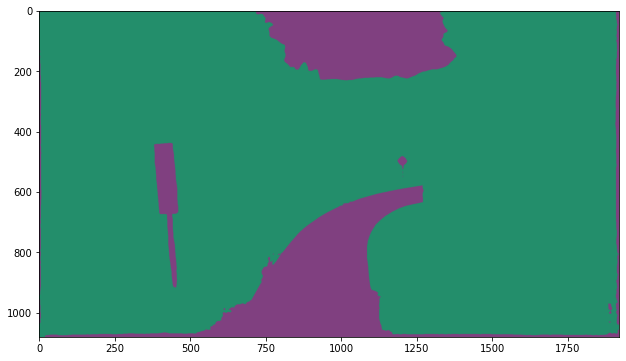

In [97]:
plt.figure(figsize=(20,6))
plt.imshow(im_vis)

##### plot_color_legend()

The function plot_color_legend() creates a color legend for the CamVid dataset, which is helpful for confirming the class assignments by the model.

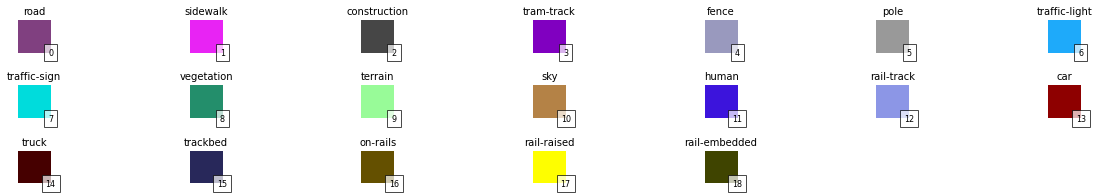

In [98]:
# Extract colors and labels from class_index dictionary.
color_array = np.array([[v["color"][2], v["color"][1], v["color"][0]] for v in class_index["labels"]]).astype(np.uint8)
class_labels = [val["name"] for val in class_index["labels"]]    

fig, ax = plt.subplots(nrows=3, ncols=7, figsize=(20, 3))
plt.subplots_adjust(wspace = 1, hspace=1)
fig.delaxes(ax[2][5])
fig.delaxes(ax[2][6])
# Display color legend.
for i, axis in enumerate(ax.flat[:19]):

    axis.imshow(color_array[i][None, None, :])
    axis.set_title(class_labels[i], fontsize = 10)
    axis.axis('off')

    # Annotate index number
    axis.text(0.5, 0.5, str(i), fontsize=8, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.7))


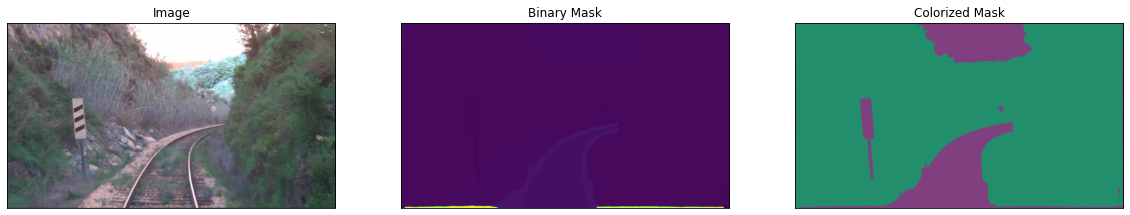

In [99]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Plot the first image on the left
axes[0].imshow(im_jpg)  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(im_id_map)  # Assuming the second image is grayscale
axes[1].set_title("Binary Mask")

# Plot the third image on the right
axes[2].imshow(im_vis)  
axes[2].set_title("Colorized Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

(-0.5, 1919.5, 1079.5, -0.5)

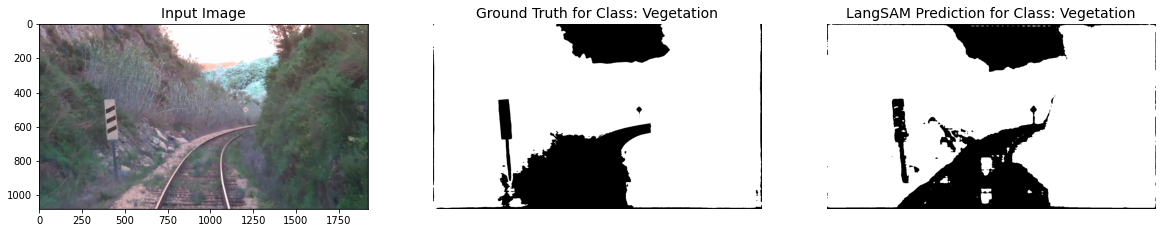

In [100]:
# Each channel in `pred_mask` contains the probabilities that the pixels 
# in the original image are associated with the class for that channel.

# Keep only the number 8,9 and 17 and replace others with 0
interested_array = np.where(np.isin(im_id_map, [8]), im_id_map, 0)

plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.title('Input Image', fontsize=14)
plt.imshow(np.squeeze(im_jpg))

plt.subplot(1,3,2)
plt.title('Ground Truth for Class: Vegetation', fontsize=14)
plt.imshow(interested_array, cmap='gray');  
plt.axis('off')

plt.subplot(1,3,3)
plt.title('LangSAM Prediction for Class: Vegetation', fontsize=14)
plt.imshow(total_mask, cmap='gray')
plt.axis('off')

In [42]:
print("Shape of the image: {}x{}".format(interested_array.shape[0], interested_array.shape[1]))

Shape of the image: 1080x1920


In [43]:
total_pixels = interested_array.shape[0] * interested_array.shape[1]
print("Total pixels (data points) in the image: {}".format(total_pixels))

Total pixels (data points) in the image: 2073600


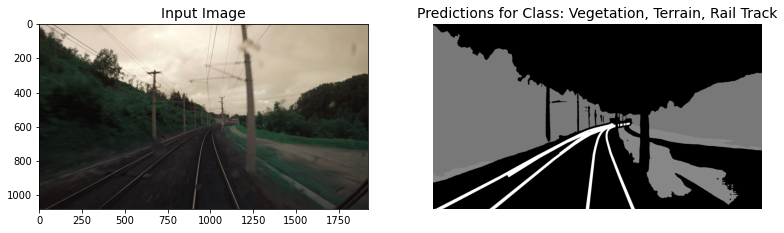

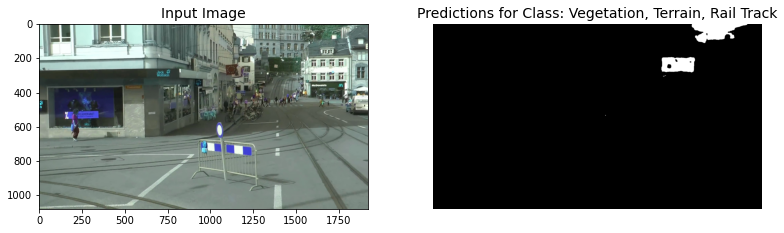

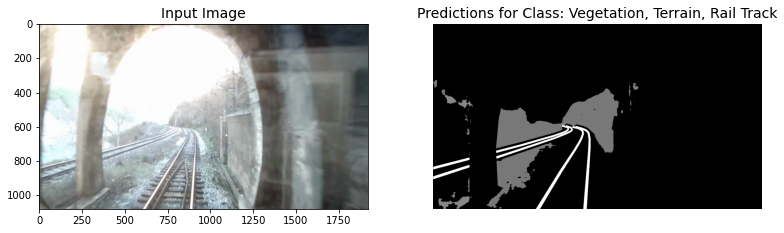

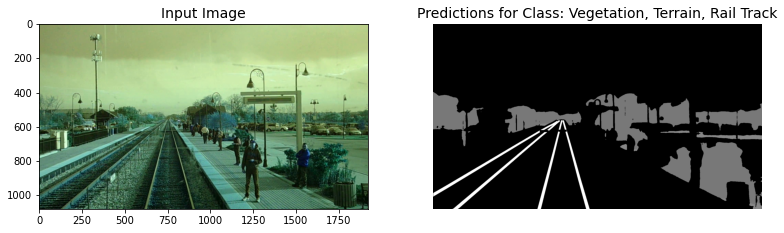

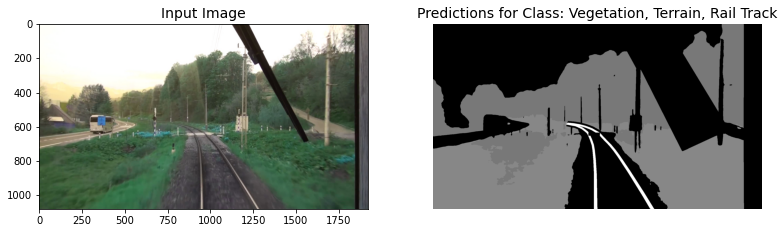

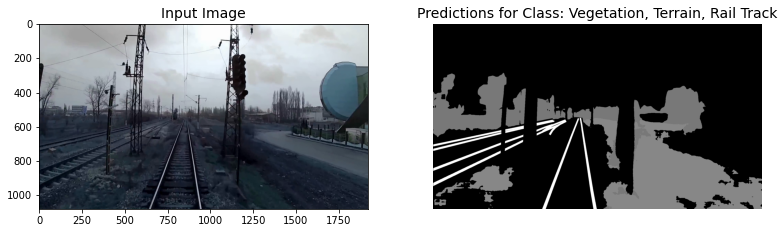

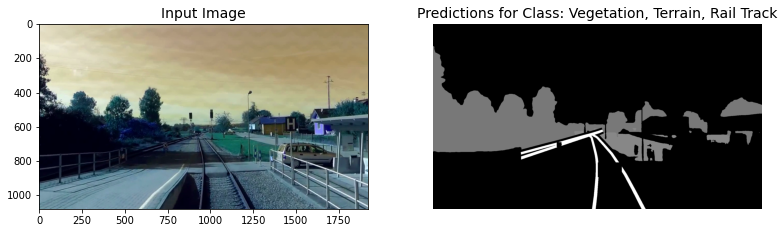

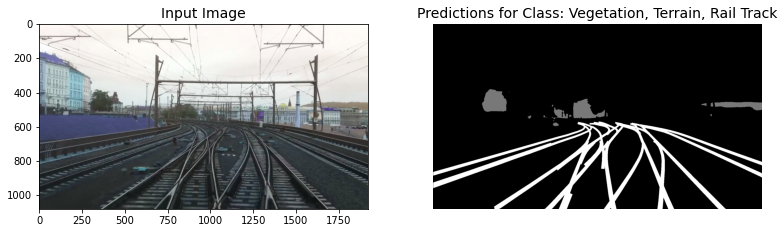

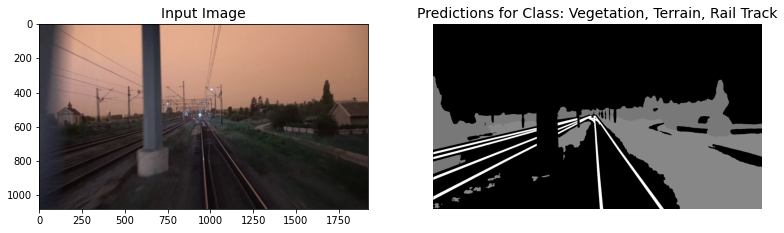

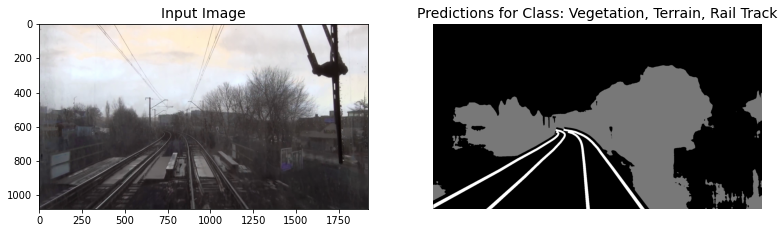

In [44]:
for i in range(10):
    image_filename = image_files[i]
    map_filename = map_files[i]

    image_path = 'jpgs/rs19_val/{}'.format(image_filename)
    label_path = 'uint8/rs19_val/{}'.format(map_filename)

    im_jpg = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    im_id_map = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    lut_bgr = config_to_rgb(inp_path_config_json, default_col = [255,255,255])[::-1] 
    im_vis = colorize_mask(im_id_map, lut_bgr)

    color_array = np.array([[v["color"][2], v["color"][1], v["color"][0]] for v in class_index["labels"]]).astype(np.uint8)
    class_labels = [val["name"] for val in class_index["labels"]] 

    interested_array = np.where(np.isin(im_id_map, [8,9,17]), im_id_map, 0)

    plt.figure(figsize=(20,6))

    plt.subplot(1,3,1)
    plt.title('Input Image', fontsize=14)
    plt.imshow(np.squeeze(im_jpg))

    plt.subplot(1,3,2)
    plt.title('Predictions for Class: Vegetation, Terrain, Rail Track', fontsize=14)
    plt.imshow(interested_array, cmap='gray');  
    plt.axis('off')

In [45]:
shape_list = []
value_frequencies = {}  # Diccionario para almacenar las frecuencias de cada valor
dict_img = {}  # Diccionario para almacenar el numero de clases diferentes para una misma imagen
count_element = 0

for i in range(8500):
    count_element += 1
    image_filename = image_files[i]
    map_filename = map_files[i]

    image_path = 'jpgs/rs19_val/{}'.format(image_filename)
    label_path = 'uint8/rs19_val/{}'.format(map_filename)


    im_jpg = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    im_id_map = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    lut_bgr = config_to_rgb(inp_path_config_json, default_col = [255,255,255])[::-1] 
    im_vis = colorize_mask(im_id_map, lut_bgr)

    color_array = np.array([[v["color"][2], v["color"][1], v["color"][0]] for v in class_index["labels"]]).astype(np.uint8)
    class_labels = [val["name"] for val in class_index["labels"]] 


    # Extract colors and labels from class_index dictionary.
    color_array = np.array([[v["color"][2], v["color"][1], v["color"][0]] for v in class_index["labels"]]).astype(np.uint8)
    class_labels = [val["name"] for val in class_index["labels"]]    

    unique_values, counts = np.unique(im_id_map, return_counts=True)

    for value, count in zip(unique_values, counts):
        #if value == 18:
            #print(f"Value: {value}, Count: {count}")
        #print(f"Value: {value}, Count: {count}")
                # Acumular frecuencia en el diccionario
        if value not in value_frequencies:
            value_frequencies[value] = {'total': count, 'count': 1}
        else:
            value_frequencies[value]['total'] += count
            value_frequencies[value]['count'] += 1

    # Keep only the number 8,9 and 17 and replace others with 0
    interested_array = np.where(np.isin(im_id_map, [8,9,17]), im_id_map, 0)
    shape = "{}x{}".format(interested_array.shape[0], interested_array.shape[1])
    shape_list.append(shape)

     # Tu lógica para obtener 'input' y 'output'
    input_data = image_filename
    output_data = unique_values

    # Agregar par clave-valor al diccionario
    dict_img[input_data] = len(output_data)

print(count_element)


KeyboardInterrupt: 

In [ ]:
dict_img

In [ ]:
# Convertir el diccionario a un DataFrame
df_img = pd.DataFrame(list(dict_img.items()), columns=['image', 'freq'])

# Mostrar el DataFrame resultante
print(df_img)
df_img[df_img["freq"]<6]

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter


# Obtener las frecuencias de los outputs
output_frequencies = Counter(dict_img.values())

# Crear el gráfico de barras
plt.bar(output_frequencies.keys(), output_frequencies.values(), color='blue', alpha=0.7)

# Agregar etiquetas y título
plt.xlabel('Count of Unique Classes')
plt.ylabel('Frequencie of Images')
plt.title('Frequency Plot of Number of Different Classes')

# Mostrar el gráfico
plt.show()

In [ ]:
class_labels = {
    0: 'road', 1: 'sidewalk', 2: 'construction', 3: 'tram-track', 4: 'fence', 5: 'pole',
    6: 'traffic-light', 7: 'traffic-sign', 8: 'vegetation', 9: 'terrain', 10: 'sky',
    11: 'human', 12: 'rail-track', 13: 'car', 14: 'truck', 15: 'trackbed',
    16: 'on-rails', 17: 'rail-raised', 18: 'rail-embedded'
}

# Convertir a DataFrame y ordenar por 'Value'
result_df = pd.DataFrame([
    {'Value': value, 'Total Frequency': info['total'], 'Count': info['count'], 
     'Average Frequency': info['total'] / info['count'] if info['count'] > 0 else 0}
    for value, info in value_frequencies.items()
]).sort_values(by='Value')

# Mapear los valores de 'Value' a las clases usando el diccionario class_labels
result_df['Class'] = result_df['Value'].map(class_labels)

# Imprimir el DataFrame resultante después del merge
result_df

In [ ]:
result_df.to_excel("class_info.xlsx")

In [ ]:
# Graficar histograma
result_df.plot(kind='bar', x='Class', y='Count', color='blue', alpha=0.7)

# Agregar etiquetas y título
plt.xlabel('Class')
plt.ylabel('Frequency of Images')
plt.title('Amount of image per Class')

# Mostrar el gráfico
plt.show()

In [ ]:
# Graficar histograma
result_df.plot(kind='bar', x='Class', y='Average Frequency', color='blue', alpha=0.7)

# Agregar etiquetas y título
plt.xlabel('Class')
plt.ylabel('Frequency of Images')
plt.title('Amount of image per Class')

# Mostrar el gráfico
plt.show()

In [ ]:
# Convertir a DataFrame y ordenar por 'Value'
result_df = result_df.sort_values(by='Average Frequency', ascending=False)

# Graficar histograma
result_df.plot(kind='bar', x='Class', y='Average Frequency', color='blue', alpha=0.7)

# Ordenar el DataFrame por 'Frequency of Images' de mayor a menor
result_df = result_df.sort_values(by='Average Frequency', ascending=True)

# Agregar etiquetas y título
plt.xlabel('Class')
plt.ylabel('Average Area (Pixels)')
plt.title('Average Area per Class')

# Mostrar el gráfico
plt.show()

In [ ]:
for value, frequency in value_frequencies.items():
    print(f"Value: {value}, Total Frequency: {frequency}")

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

data_str = shape_list

# Contar la frecuencia de cada elemento
counter = Counter(data_str)

# Extraer los valores y las frecuencias
values = list(counter.keys())
frequencies = list(counter.values())

# Crear el histograma
plt.bar(values, frequencies, edgecolor='black', alpha=0.7)

# Agregar etiquetas y título
plt.xlabel('Shapes of Image')
plt.ylabel('Freqency')
plt.title('Shapes Frequency')

# Mostrar el histograma
plt.show()

In [ ]:
class_labels

In [ ]:
unique_values, counts = np.unique(im_id_map, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

In [ ]:
# Count occurrence of element '8' in numpy array
veg_percent = (interested_array == 8).sum()/(interested_array.shape[0] * interested_array.shape[1])*100
print('Total occurences of "8 (vegetation)" in array (percentage): {}%'.format(np.round(veg_percent)))

In [ ]:
# Count occurrence of element '9' in numpy array
terrain_percent = (interested_array == 9).sum()/(interested_array.shape[0] * interested_array.shape[1])*100
print('Total occurences of "9 (terrain)" in array (percentage): {}%'.format(np.round(terrain_percent)))

In [ ]:
# Count occurrence of element '17' in numpy array
rail_percent = (interested_array == 17).sum()/(interested_array.shape[0] * interested_array.shape[1])*100
print('Total occurences of "17 (Metal rail)" in array (percentage):{}%'.format(np.round(rail_percent)))

In [ ]:
# Count occurrence of element '9' in numpy array
terrain_percent = (interested_array == 9).sum()/(interested_array.shape[0] * interested_array.shape[1])*100
print('Total occurences of "9" in array: ', terrain_percent)

In [ ]:
# Count occurrence of element '9' in numpy array
rail_percent = (interested_array == 17).sum()/(interested_array.shape[0] * interested_array.shape[1])*100
print('Total occurences of "17" in array: ', rail_percent)

In [ ]:
def get_joined_img(jpg_folder, uint8_folder, lut_bgr, blend_vals):
    im_id_col = np.zeros((uint8_folder.shape[0], uint8_folder.shape[1], 3), np.uint8)
    for c in range(3):
        im_id_col[:,:,c] = lut_bgr[c][im_id_map] #apply color coding
    return (jpg_folder*blend_vals[0]+im_id_col*blend_vals[1]).astype(np.uint8) #blend all three data sources

In [ ]:
blended_img = get_joined_img(im_jpg, im_id_map, lut_bgr, blend_vals=[0,0.25,0.1])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first image on the left
axes[0].imshow(im_jpg)  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(blended_img)  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## 2 Model Inference using TensorFlow Hub

### - 2.1 Load the Model from TensorFlow Hub

TensorFlow Hub contains many different pre-trained segmentation models. 

Here we will use the _________ segmentation model trained on ______ Dataset. The model has been pre-trained on the ______ classification task and fine-tuned on __________.

We can load the model into memory using the url to the model page.

In [ ]:
model_url =  'https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1'
print('loading model: ', model_url)

seg_model = hub.load(model_url)
print('\nmodel loaded!')

In [ ]:
# Add a batch dimension which is required by the model.
image = np.expand_dims(im_jpg, axis=0)/255.0

### 2.2 Perform Inference


Before we formalize the code to process several images and post-process the results, let's first see how to perform inference on a single image and study the output from the model.

#### 2.2.1 Call the Model's predict() Method

In [ ]:
# Make a prediction using the first image in the list of images.
pred_mask = seg_model.predict(image)

# The predicted mask has the following shape: [B, H, W, C].
print('Shape of predicted mask: ', pred_mask.shape)

#### 2.2.2 Post-Process the Predicted Segmentation Mask

The predicted segmentation mask returned by the model contains a separate channel for each class. Each channel contains the probability that a given pixel from the input image is associated with the class for that channel. This data, therefore, requires some post-processing to obtain meaningful results. Several steps need to be performed to arrive at a final visual representation.

- Remove the batch dimension and the background class.
- Assign a class label to every pixel in the image based on the highest probability score across all channels.
- The previous step results in a single-channel image that contains the class labels for each pixel. We, therefore, need to map those class IDs to RGB values so we can visualize the results as a color-coded segmentation map

##### Remove Batch Dimension and Background Class

In [ ]:
# Convert tensor to numpy array.
pred_mask = pred_mask.numpy()

# The 1st label is the background class added by the model, but we can remove it for this dataset.
pred_mask = pred_mask[:,:,:,1:]

# We also need to remove the batch dimension.
pred_mask = np.squeeze(pred_mask)

# Print the shape to confirm: [H, W, C]. 
print('Shape of predicted mask after removal of batch dimension and background class: ', pred_mask.shape)

Visualize the Intermediate Results

In [ ]:
# Each channel in `pred_mask` contains the probabilities that the pixels 
# in the original image are associated with the class for that channel.
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.title('Input Image', fontsize=14)
plt.imshow(np.squeeze(image))

plt.subplot(1,3,2)
plt.title('Predictions for Class: Road', fontsize=14)
plt.imshow(pred_mask[:,:,17], cmap='gray');  # Class 17 corresponds to the 'road' class
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Predictions for Class: Sky', fontsize=14)
plt.imshow(pred_mask[:,:,21], cmap='gray');  # Class 21 corresponds to the 'sky' class
plt.axis('off');

In [ ]:
# Assign each pixel in the image a class ID based on the channel that contains the  
# highest probability score. This can be implemented using the `argmax` function.
pred_mask_class = np.argmax(pred_mask, axis=-1)

plt.figure(figsize=(20,8)); 

plt.subplot(1,2,1)
plt.title('Input Image', fontsize=12)
plt.imshow(np.squeeze(image))

plt.subplot(1,2,2)
plt.title('Segmentation Mask', fontsize=12)
plt.imshow(pred_mask_class, cmap='gray') 
plt.gca().add_patch(Rectangle((450,200),200,3, edgecolor='red', facecolor='none', lw=.5));

##### Convert the Single Channel Mask to a Color Representation

### 3 Formalize the Implementation

#### 3.1 image_overlay()

get_joined_img() is a helper function to overlay an RGB mask on top of the original image to better appreciate how the predictions line up with the original image.

In [ ]:
def image_overlay(im_jpg, mask, blend_vals=[0.65,0.25]):
    return (im_jpg*blend_vals[0]+mask*blend_vals[1]).astype(np.uint8) #blend all data sources

In [ ]:
colorized_pred_mask_class = colorize_mask(pred_mask_class, lut_bgr)

In [ ]:
blended_mask = image_overlay(im_jpg, colorized_pred_mask_class)

In [ ]:
plt.figure(figsize=(20,12))

plt.subplot(1,3,1)
plt.title('Input Image', fontsize=14)
plt.imshow(np.squeeze(image))
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Grayscale Segmentation', fontsize=14)
plt.imshow(pred_mask_class, cmap='gray') 
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Color Segmentation', fontsize=14)
plt.imshow(blended_mask, cmap='gray') 
plt.axis('off');

#### 3.2 run_inference()

To perform inference on several images, we define the function below, which accepts a list of images and a pre-trained model. This function also handles all of the post-processing required to compute the final segmentation mask as well as the overlay.

In [ ]:
def run_inference(images, model, lut_bgr):
    
    for img in images:
        
        # Forward pass through the model (convert the tensor output to a numpy array).
        pred_mask = model.predict(img).numpy()
        
        # Remove the background class added by the model.
        pred_mask = pred_mask[:,:,:,1:]
        
        # Remove the batch dimension.
        pred_mask = np.squeeze(pred_mask)
        
        # `pred_mask` is a numpy array of shape [H, W, 32] where each channel contains the probability  
        # scores associated with a given class. We still need to assign a single class to each pixel 
        # which is accomplished using the argmax function across the last dimension to obtain the class labels.
        pred_mask_class = np.argmax(pred_mask, axis=-1)

        # Convert the predicted (class) segmentation map to a color segmentation map.
        pred_mask_rgb = colorize_mask(pred_mask_class, lut_bgr)
                
        fig = plt.figure(figsize=(20, 15))
        
        # Display the original image.
        ax1 = fig.add_subplot(1,3,1)
        ax1.imshow(img[0])
        ax1.title.set_text('Input Image')
        plt.axis('off')

        # Display the predicted color segmentation mask. 
        ax2 = fig.add_subplot(1,3,2)
        ax2.set_title('Predicted Mask')
        ax2.imshow(pred_mask_rgb)
        plt.axis('off')

        # Display the predicted color segmentation mask overlayed on the original image.
        overlayed_image = image_overlay(img[0], pred_mask_rgb)
        ax4 = fig.add_subplot(1,3,3)
        ax4.set_title('Overlayed Image')
        ax4.imshow(overlayed_image)
        plt.axis('off')
        
        plt.show()


In [ ]:
images = [image]

run_inference()

##### 3.3 Make Predictions on the Sample Images
Now, let's use this function to perform inference on the sample images using the three models we selected above.

In [ ]:
run_inference(images, seg_model, lut_bgr)

## Predicted Mask vs Ground Truth Mask

In [ ]:
fig = plt.figure(figsize=(20, 15))
# Display the original image.
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(im_jpg)
ax1.title.set_text('Input Image')
plt.axis('off')

# Display the predicted color segmentation mask. 
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Predicted Mask')
ax2.imshow(colorized_pred_mask_class)
plt.axis('off')

# Display the predicted color segmentation mask overlayed on the original image.
ax4 = fig.add_subplot(1,3,3)
ax4.set_title('Ground Truth Map')
ax4.imshow(im_vis)
plt.axis('off')

plt.show()
